# F1 マルコフジャンプ

- 0, 1, 2の3状態間をランダムに遷移する．
- 状態間の自由エネルギー変化を dG とする．
- dG[0] +dG[1] + dG[2] が1サイクルあたりの自由エネルギー変化．これが負であれば順方向にサイクルが回る．正であれば逆方向にサイクルが回る．
- 定常状態において，各状態にいる確率 $P$は異なる．サイクルが回る方向で，どこかに障壁があれば，その手前にたまる．
- しかし，正味の流れ $J$ は，遷移によらない（0-1, 1-2, 2-3のどの間でも同じ）．

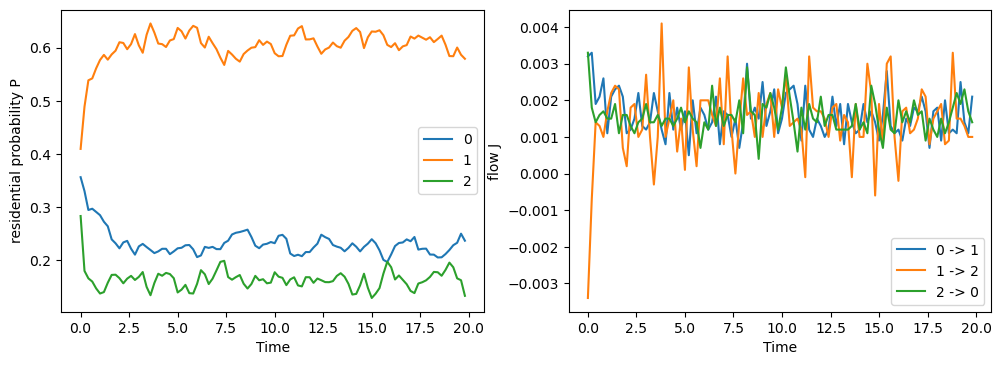

In [143]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

N = 500 # 粒子の数
stepN = 2000 # 計算ステップ数
avgN = 20 # avgNステップごとに平均を計算する

dt = 0.01 # 時間刻み

dG = np.array([-3, -2, 1]) # 0->1, 1->2, 2->0 の自由エネルギー変化 (kBT). 3つの数字の合計が1サイクル当たりの自由エネルギー変化．

p0 = 0.01 
pf = p0*np.full(3, 1) # 前向き遷移率（単位ステップあたり） pf[i]+pb[i] は1を超えないようにする．
pb = p0*np.exp(dG)  # 後ろ向き遷移率（単位ステップあたり）

s = np.random.randint(0, 3, N) # 状態 (0..2)．初期値はランダムに決める．

c = 0 # avgNステップごとに1つ増える．
P = [[0], [0], [0]] # 各状態にいる粒子数
J = [[0], [0], [0]] # 流れ

for i in range(stepN):
    r = np.random.rand(N)  # あらかじめ N 個の乱数（0から1の間の一様乱数）を作っておく．
    for k in range(N):
        if r[k] < pf[s[k]]:
            J[s[k]][c] += 1            
            s[k] = (s[k] + 1)%3
        elif r[k] < pf[s[k]] + pb[s[k]]:   
            s[k] = (s[k] - 1)%3            
            J[s[k]][c] -= 1
          
        P[s[k]][c] += 1
        
    if i>0 and i%avgN ==0: # 次の平均サイクルに入る
        c += 1
        for i in range(3):
            P[i] = np.append(P[i], [0])
            J[i] = np.append(J[i], [0])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4), dpi = 100)

t = dt*np.arange(0, c+1)*avgN

for i in range(3):
    ax1.plot(t, P[i]/N/avgN, label = i)
    ax2.plot(t, J[i]/N/avgN, label = '{} -> {}'.format(i, (i+1)%3))
    
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('residential probability P')

ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('flow J')

plt.show()

# F2 ギレスピーアルゴリズム

感染症伝播のモデルであるSIRモデル（演習問題(4.3)）をギレスピーアルゴリズムで計算し，微分方程式による結果（ソースコードD3）と比較する．<br>
V が体積で，全個体の密度(S+I+R)/Vは1となっている．Vが小さいと個体数が減少し，揺らぎが大きくなる．

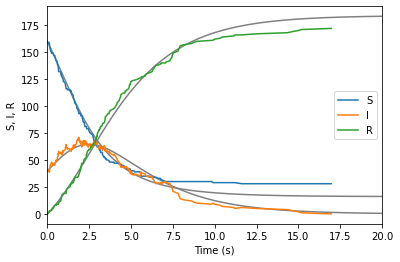

In [134]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

from scipy.integrate import odeint # 状微分方程式用ライブラリ

p = 1 # 感染率
q = 0.4 # 回復率
I0 = 0.2 #感染者の初期値（最大1）

tmax = 20

# ギレスピー

V = 200.0 # 体積

T = [0] # 時間
S = [V*(1-I0)]
I = [V*I0]
R = [0]

while T[-1]<tmax and I[-1] != 0:  # 時間がtmaxに達するか，感染者がいなくなると（a0=0となってしまう）計算を止める．
    # propensity functionの計算
    a_inf = p*S[-1]*I[-1]/V
    a_rec = q*I[-1]
    
    a0 = a_inf + a_rec
    
    if a_inf/a0 > np.random.rand(): # 感染
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
    else:  # 回復
        S.append(S[-1])
        I.append(I[-1] -1 )
        R.append(R[-1]+1)
        
    T.append(T[-1] -np.log(np.random.rand())/a0) # 反応時間の計算
    
    
# 微分方程式

def func(var, t):
    S, I, R = var
    dSdt = -p*S*I
    dIdt = p*S*I - q*I
    dRdt = q*I
    return [dSdt, dIdt, dRdt]


init = [1 - I0, I0, 0]
t = np.linspace(0, tmax, 1000)

r = odeint(func, init, t, args = ())

plt.plot(t, r[:,0]*V, color = 'gray')
plt.plot(t, r[:,1]*V, color = 'gray')
plt.plot(t, r[:,2]*V, color = 'gray')

plt.plot(T, S, label = 'S')
plt.plot(T, I, label = 'I')
plt.plot(T, R, label = 'R')


plt.xlabel('Time (s)')
plt.ylabel('S, I, R')

plt.xlim([0, tmax])
plt.legend()

plt.show()

# F3 中心極限定理

中心極限定理によれば，平均$\mu$, 分散$\sigma^2$の母集団から$N$個のサンプルを抽出した時，その平均値は平均 $\mu$, 分散 $\sigma^2$ / N の正規分布に従う．<br>
ここでは，指数分布に従う母集団を考える．

- 平均 $\mu$ の指数分布（分散は$\sigma^2$）に従う乱数を $N$ 個作成し，平均値 $m$ を計算．
- これを $M$ 回行い，$m$ の分布を調べる．
- この分布は，$N$ が十分に大きければ中心極限定理に従う．

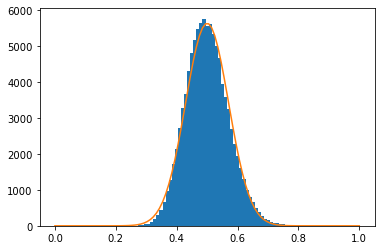

In [59]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

M = 100000
N = 50 

def norm(x, mu, sigma2): # 平均 mu, 分散sigma2の正規分布
    return (np.exp(-(x-mu)**2/2/sigma2)) / np.sqrt(2*np.pi*sigma2)

mu = 0.5

m = np.zeros(M)
for i in range(M):
    r = np.random.exponential(mu, N)
    m[i] = np.mean(r)

binN = 100
x = np.linspace(0,1,binN)
    
plt.hist(m, bins = x)

plt.plot(x, norm(x, mu, mu*mu/N)*M/binN)
plt.show()

# F4 ランダムウォークとMSDプロット

自由空間でのランダムウォークと，そのMSDプロット．

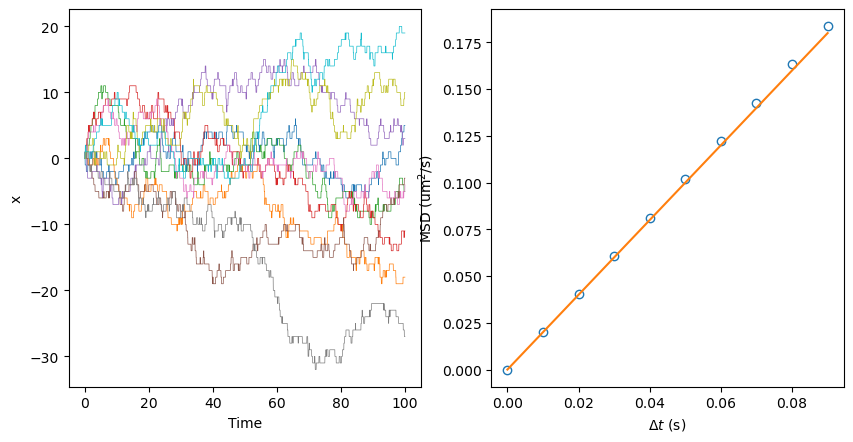

In [7]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    

# ランダムウォーク．p: １ステップあたりの確率．N: ステップの数．
def randomwalk(tau, w, d, N):     
    r = np.random.rand(N)
       
    x = np.zeros(N)
    x[0] = 0 # 初期位置
    p = w*tau
    for i in range(N-1): # ここはリストのまま計算すればかなり高速化できますが，分かりやすくするため，逐次的に計算しています．
        if r[i]<p:
            x[i + 1] = x[i]  + d
        elif r[i]<2*p:
            x[i + 1] = x[i]  - d  
        else:
            x[i + 1] = x[i]
    t = np.linspace(0, (N-1)*tau, N)
    
    return t, x

# 時系列 x[] のMSDを計算する（点の数 = msdN）．
def MSD(x, msdN):
    msd = np.zeros(msdN)
    n = len(x)  # 点の数
    for m in range(0, msdN):   
        dx = (x[m:n:1] - x[0:n-m:1])**2  # m*dt だけ離れた2点間の差の2乗を足していく．
        msd[m] += dx.sum() / len(dx)
    return msd


fig = plt.figure(figsize=(10,5), dpi=100)

ax1 = fig.add_subplot(121, xlabel = 'Time', ylabel = 'x')

# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
tau = 0.01 # サイコロを振る時間間隔
d = 1 # 1歩で進む距離
w = 1 # 単位時間当たりの遷移率
N = 10000 # ステップ数
msdN = 10 # MSDを計算する点の数
msd = np.zeros(msdN)
for i in range(10):
    t, x = randomwalk(tau, w, d, N) 
    ax1.plot(t, x, lw = 0.5)  # lwは線の太さ．
    
    msd += MSD(x, msdN)  # MSDの計算
msd /= 10

# MSDのプロット
dt = np.linspace(0, (msdN-1)*tau, msdN)
D = w*d*d  # 拡散係数
theory = 2*D*dt   # 理論曲線   MSD = 2DΔt

ax2 = fig.add_subplot(122, xlabel = r'$\Delta t$ (s)', ylabel = r'MSD (um$^2$/s)')
ax2.plot(dt, msd, 'o', markerfacecolor='none')
ax2.plot(dt, theory) 

plt.show()

# F5 自己相関関数

6.8節参照．

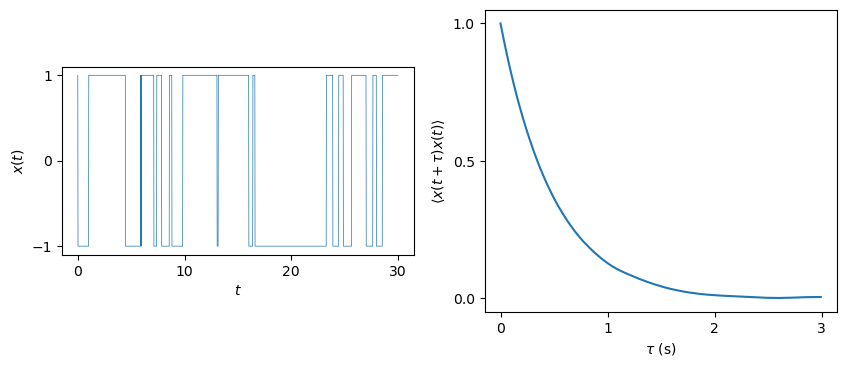

In [337]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    

# ランダムウォーク．p: １ステップあたりの確率．N: ステップの数．
def randomwalk(tau, w, d, N):  # 1, -1の間をランダムに行き来する．   
    r = np.random.rand(N)
       
    x = np.zeros(N)
    x[0] = 1 # 初期位置
    p = w*tau
    for i in range(N-1):
        if r[i]<p:
            x[i + 1] = -x[i]
        else:
            x[i + 1] = x[i]
    t = np.linspace(0, (N-1)*tau, N)
    
    return t, x

# 時系列 x[] の自己相関関数を計算する（点の数 = M）．
def Corr(x, M):
    c = np.zeros(M)
    n = len(x)  # 点の数
    for m in range(0, M):   
        d = x[m:n-1] * x[0:n-m-1]  
        c[m] = d.sum() / len(d)
    return c


fig = plt.figure(figsize=(10,4), dpi=100)

# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
tau = 0.01 # サイコロを振る時間間隔
d = 1 # 1歩で進む距離
w = 1 # 単位時間当たりの遷移率
N = 1000000 # ステップ数
M = 300 # 自己相関関数を計算する点の数
    
t, x = randomwalk(tau, w, d, N) 

plotN = 3000 # プロットするの点の数
ax1 = fig.add_subplot(121, xlabel = r'$t$', ylabel = r'$x(t)$')
ax1.plot(t[:plotN], x[:plotN], lw = 0.5)  # lwは線の太さ．
ax1.set_xticks([0, 10, 20, 30])
ax1.set_yticks([-1, 0, 1])
ax1.set_aspect(8)

dt = np.linspace(0, (M-1)*tau, M)
C = Corr(x, M)  # 自己相関関数の計算

ax2 = fig.add_subplot(122, xlabel = r'$\tau$ (s)', ylabel = r'$\langle x(t+\tau)x(t)\rangle$')
ax2.plot(dt, C, '-', markerfacecolor='none')
ax2.set_xticks([0,1,2,3])
ax2.set_yticks([0,0.5,1])

plt.show()

# F6 拡散方程式

6.11節参照．<br>
分布が拡散によって拡がる様子を拡散方程式で計算．

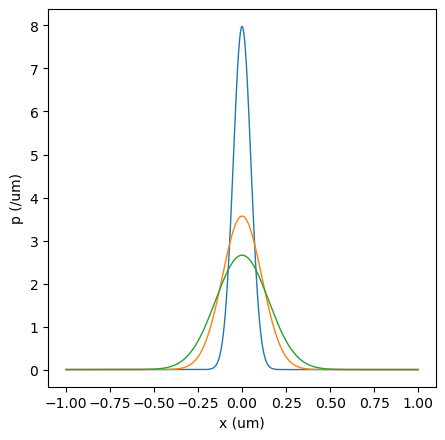

In [362]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

# 拡散方程式を解く．周期境界．
def diffusionequation(dt, dx, T, L, D):  # 時間刻み dt で T だけ計算．慶のサイズは L, 空間の刻み幅 dx, 拡散係数 D．  
    n = int(T / dt)  # ステップ数
    nx = int(L/dx) # 空間の分割数
    
    # 初期分布．幅dの正規分布
    x = np.linspace(-L/2, L/2-dx, nx)
    d = 0.5E-7
    p = np.exp(-0.5*(x/d)**2)/np.sqrt(2*np.pi*d*d)
    
    # 拡散方程式に従って時間発展
    for i in range(n):
        diff = D*(np.roll(p, 1) - 2*p + np.roll(p,-1))/dx/dx  # 拡散項．np.roll(p, 1) はリストを1つずらす．
        p += diff*dt
    
    return x, p


# パラメータ設定
D = 1E-16 # 拡散係数 (m^2/s)
  
L = 2E-6
dx = L/1000
dt = 1E-2 # (s) 計算の時間刻み

plt.figure(figsize=(5,5), dpi=100)
for T in [0, 50, 100]: # 時間を変えて計算．
    x, p = diffusionequation(dt, dx, T, L, D)  # 拡散方程式による計算
    plt.plot(x*1E6, p*1E-6, lw = 1)  # lwは線の太さ．
        
plt.xlabel('x (um)')
plt.ylabel('p (/um)')

plt.show()

# F7 移流拡散方程式

6.6節参照．<br>
一定外力下で拡散で拡がる様子を移流拡散方程式により計算．

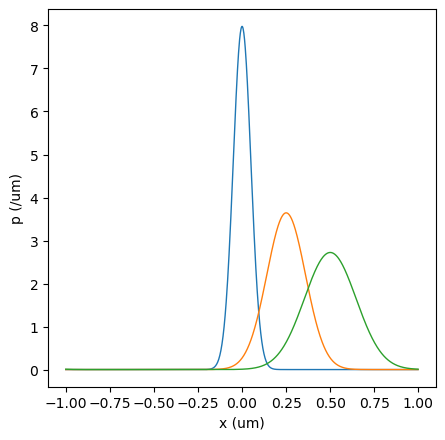

In [363]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

# 移流拡散方程式を解く．周期境界．
def diffusionequation(dt, dx, T, L, D):  # 時間刻み dt で T だけ計算．慶のサイズは L, 空間の刻み幅 dx, 拡散係数 D．  
    n = int(T / dt)  # ステップ数
    nx = int(L/dx) # 空間の分割数
    
    # 初期分布．幅dの正規分布
    x = np.linspace(-L/2, L/2-dx, nx)
    d = 0.5E-7
    p = np.exp(-0.5*(x/d)**2)/np.sqrt(2*np.pi*d*d)
    
    # 拡散方程式に従って時間発展
    for i in range(n):
        conv = -u * (np.roll(p,-1) - p)/dx # 移流項
        diff = D*(np.roll(p, 1) - 2*p + np.roll(p,-1))/dx/dx  # 拡散項．np.roll(p, 1) はリストを1つずらす．
        p += (conv + diff)*dt
    
    return x, p


# パラメータ設定
D = 1E-16 # 拡散係数 (m^2/s)
u = 5E-9 # 速度 (m/s)
  
L = 2E-6
dx = L/1000
dt = 1E-2 # (s) 計算の時間刻み

plt.figure(figsize=(5,5), dpi=100)
for T in [0, 50, 100]: # 時間を変えて計算．
    x, p = diffusionequation(dt, dx, T, L, D)  # 拡散方程式による計算
    plt.plot(x*1E6, p*1E-6, lw = 1)  # lwは線の太さ．
        
plt.xlabel('x (um)')
plt.ylabel('p (/um)')

plt.show()

# F8 ランジュバン方程式

ランジュバン方程式：
$$\gamma \dot x=-kx+\xi,\qquad \langle \xi(t)\xi(s)\rangle=2k_\mathrm{B}T\gamma\delta(t-s).$$
これを差分すると，
$$x_{n+1}-x_{n}=-\frac k\gamma x_n\Delta t+w r_n,\qquad w=\sqrt{\frac{2k_\mathrm{B}T}\gamma\Delta t}.$$
ただし，$r_n$は正規分布に従う乱数（平均0, 分散1）．
熱揺動力の項では，ルートの中に$\Delta t$が入ることに注意．

ばね定数 $k$, 摩擦係数 $\gamma$では，時定数 $\tau=\frac \gamma k$ で平衡状態に緩和する．また，このバネ＋摩擦の系はローパスフィルタ―とみなすこともでき，$\tau$ よりも短い時間スケールの運動はなまってしまう． 


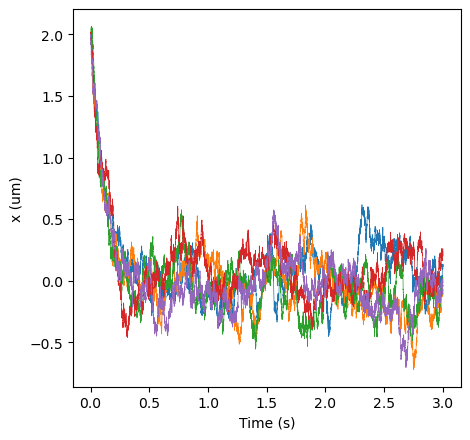

In [29]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)

# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, x0, k, gamma):  # 時間刻み dt で T だけ計算   
    n = int(T / dt)  # ステップ数
    
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
    r = np.random.standard_normal(size = n - 1) # n-1個の正規乱数（平均0, 分散1）を発生．
       
    x = np.zeros(n)
    x[0] = x0 # m, 初期位置
    for i in range(n-1):
        f = - k * x[i] # 調和ポテンシャルからうける力
        x[i + 1] = x[i] + dt * f / gamma + w * r[i]
        
    t = np.linspace(0, T - dt, n)
    return t, x


# パラメータ設定
gamma = 1E-8 # (kg/s)
tau = 0.1 # (s) トラップの時定数
k = gamma/tau   # トラップのばね定数
   
T = 3 # (s) 計算時間
dt = 1E-4 # (s) 計算の時間刻み
x0 = 2E-6 # (m) 初期位置．少し離れたところからスタートして，緩和の様子を見てみる．

# 同じ計算を5回して重ねてプロット．

plt.figure(figsize=(5,5), dpi=100)
for i in range(5):
    t, x = langevin(dt, T, x0, k, gamma)  # ランジュバン方程式による計算
    plt.plot(t, x *1E6, lw = 0.5)  # lwは線の太さ．
        
plt.xlabel('Time (s)')
plt.ylabel('x (um)')

plt.show()